##### Использованные модели машинного обучения:
1. K-Nearest Neighbour(KNN)
2. Support Vector Machine(SVM)
3. Gradient Boost
4. Extreme Gradient Boosting(XGBC)

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
import missingno as mso
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

for dirname, _, filenames in os.walk('/kaggle/input'):
    for fn in filenames:
        print(os.path.join(dirname, fn))

In [18]:
data=pd.read_csv("./kaggle/seattle-weather.csv")
print(data.shape)
data.tail()

(1461, 6)


,date,precipitation,temp_max,temp_min,wind,weather
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun
1460,2015-12-31,0.0,5.6,-2.1,3.5,sun


In [21]:
rain=len(data[data.weather=="rain"])
sun=len(data[data.weather=="sun"])
drizzle=len(data[data.weather=="drizzle"])
snow=len(data[data.weather=="snow"])
fog=len(data[data.weather=="fog"])
print("Процент Дождя: {:2f}%".format((rain/(len(data.weather))*100)))
print("Процент Солнечной погоды: {:2f}%".format((sun/(len(data.weather))*100)))
print("Процент легких осадков: {:2f}%".format((drizzle/(len(data.weather))*100)))
print("Процент Снега: {:2f}%".format((snow/(len(data.weather))*100)))
print("Процент Тумана: {:2f}%".format((fog/(len(data.weather))*100)))

Процент Дождя: 43.874059%
Процент Солнечной погоды: 43.805613%
Процент легких осадков: 3.627652%
Процент Снега: 1.779603%
Процент Тумана: 6.913073%


### Просмотр доп. переменных

In [22]:
data[["precipitation","temp_max","temp_min","wind"]].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


[Text(0.5, 0, 'Ветер')]

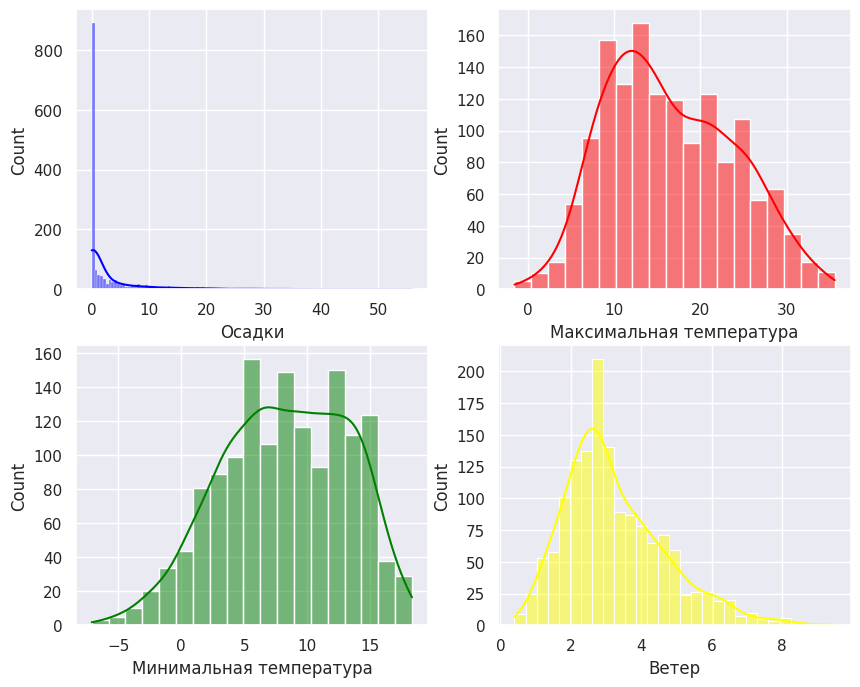

In [30]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
ax_precipitation = sns.histplot(data=data,x="precipitation",kde=True,ax=axs[0,0],color='blue')
ax_temp_max = sns.histplot(data=data,x="temp_max",kde=True,ax=axs[0,1],color='red')
ax_temp_min = sns.histplot(data=data,x="temp_min",kde=True,ax=axs[1,0],color='green')
ax_wind = sns.histplot(data=data,x="wind",kde=True,ax=axs[1,1],color='yellow')

ax_precipitation.set (xlabel='Осадки')
ax_temp_max.set (xlabel='Максимальная температура')
ax_temp_min.set (xlabel='Минимальная температура')
ax_wind.set (xlabel='Ветер')



### Violin plot

<Axes: xlabel='wind'>

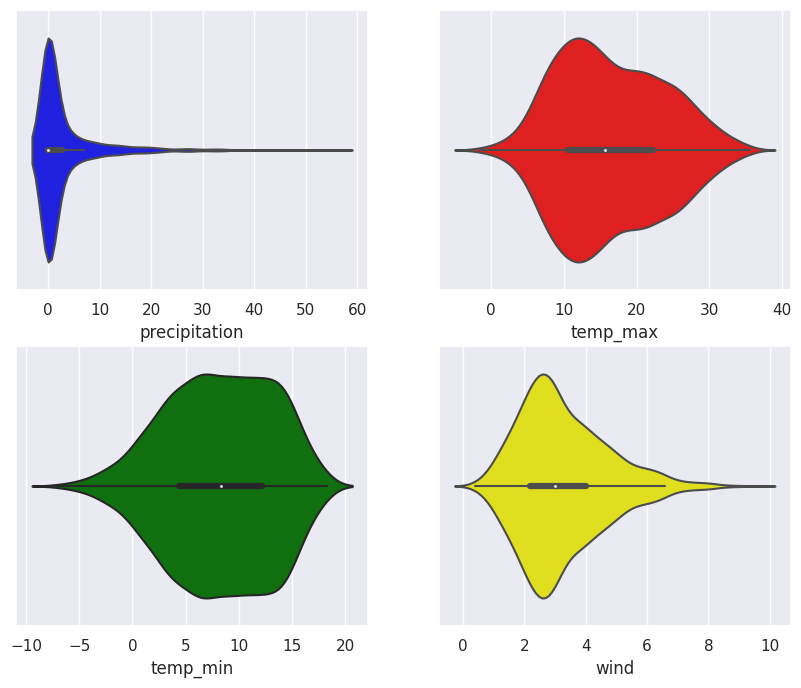

In [32]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.violinplot(data=data,x="precipitation",kde=True,ax=axs[0,0],color='blue')
sns.violinplot(data=data,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.violinplot(data=data,x="temp_min",kde=True,ax=axs[1,0],color='green')
sns.violinplot(data=data,x="wind",kde=True,ax=axs[1,1],color='yellow')

<Axes: >

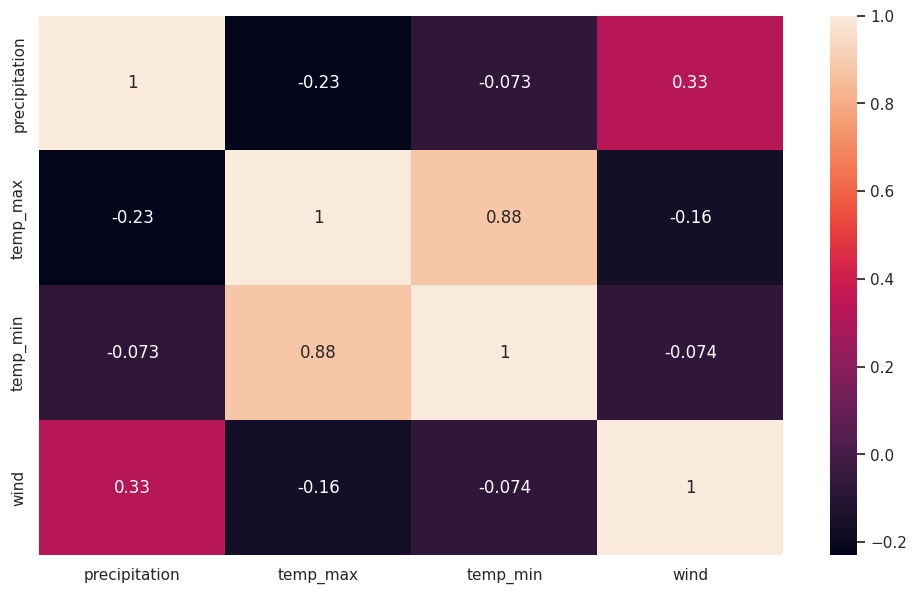

In [40]:
plt.figure(figsize=(12,7))
sns.heatmap(data[["precipitation","temp_max","temp_min","wind"]].corr(),annot=True)

In [41]:
data.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

<Axes: xlabel='wind', ylabel='Count'>

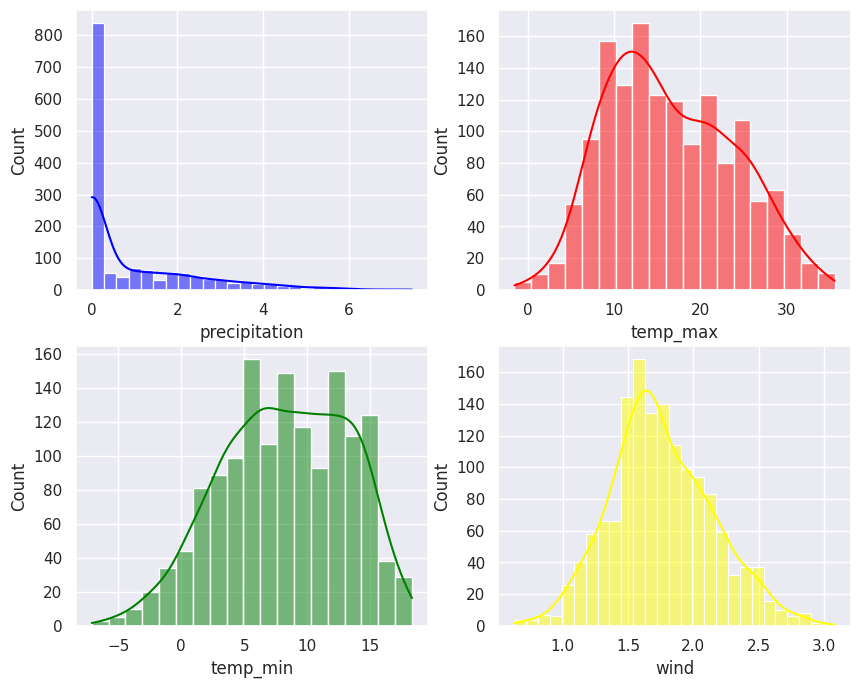

In [47]:
df=data.drop(["date"],axis=1) # Дата не нужна

df.precipitation=np.sqrt(df.precipitation)
df.wind=np.sqrt(df.wind)

sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=df,x="precipitation",kde=True,ax=axs[0,0],color='blue')
sns.histplot(data=df,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.histplot(data=df,x="temp_min",kde=True,ax=axs[1,0],color='green')
sns.histplot(data=df,x="wind",kde=True,ax=axs[1,1],color='yellow')

In [48]:
lc=LabelEncoder()
df["weather"]=lc.fit_transform(df["weather"])
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.000000,12.8,5.0,2.167948,0
1,3.301515,10.6,2.8,2.121320,2
2,0.894427,11.7,7.2,1.516575,2
3,4.505552,12.2,5.6,2.167948,2
4,1.140175,8.9,2.8,2.469818,2


In [49]:
x=((df.loc[:,df.columns!="weather"]).astype(int)).values[:,0:]
y=df["weather"].values
df.weather.unique()
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=2)

### Алгоритмы и обучение модели

### K-NEAREST NEIGHBOR

In [50]:
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
print("KNN Accuracy:{:.2f}%".format(knn.score(x_test,y_test)*100))

KNN Accuracy:74.15%


### SUPPORT VECTOR MACHINE

In [51]:
svm=SVC()
svm.fit(x_train,y_train)
print("SVM Accuracy:{:.2f}%".format(svm.score(x_test,y_test)*100))

SVM Accuracy:79.59%


### GRADIENT BOOSTING

In [52]:
gbc=GradientBoostingClassifier(subsample=0.5,n_estimators=450,max_depth=5,max_leaf_nodes=25)
gbc.fit(x_train,y_train)
print("Gradient Boosting Accuracy:{:.2f}%".format(gbc.score(x_test,y_test)*100))

Gradient Boosting Accuracy:78.91%


### EXTREME GRADIENT BOOSTING OR XGBCLASSIFIER

In [53]:
import warnings
warnings.filterwarnings('ignore')
xgb=XGBClassifier()
xgb.fit(x_train,y_train)
print("XGB Accuracy:{:.2f}%".format(xgb.score(x_test,y_test)*100))

XGB Accuracy:80.27%


In [56]:
def predict(input):
    ot=xgb.predict(input)
    print("Предсказанная погода: ")
    if(ot==0):
        print("Небольшие осадки")
    elif(ot==1):
        print("Туман")
    elif(ot==2):
        print("Дождь")
    elif(ot==3):
        print("Снег")
    else:
        print("Солнечно")

In [57]:
input=[[0, 1, 2, 3]]
predict(input)

Предсказанная погода: 
Снег


In [58]:
input=[[0, 22, 14, 3]]
predict(input)

Предсказанная погода: 
Солнечно


In [59]:
input=[[10, 8, 10, 10]]
predict(input)

Предсказанная погода: 
Дождь


In [67]:
input=[[0, 7.2, 0.6, 2.6]]
predict(input)

Предсказанная погода: 
Солнечно
